## Import Data


In [65]:
# === Import ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [66]:
# === 1. Load & Cleaning ===
data = pd.read_csv("DukuhKupang.csv")
drop_cols = ['Datetime','Timezone','AQI CN','AQI US','HCHO (ppb)','TVOC (ppb)']
data = data.drop(columns=drop_cols).dropna().drop_duplicates()

In [67]:
print(data.isna().sum())
print(data.isnull().sum())
print(data.duplicated().sum())

PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
0


In [68]:
# Outlier removal (1x saja, bukan looping panjang)
Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
IQR = Q3 - Q1
mask = ~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis=1)
data = data[mask]
data

,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
25,16.0,35,427,37.6,99.6,49
26,12.0,30,426,37.6,99.6,48
27,16.0,35,422,37.5,99.4,50
28,12.0,18,421,37.3,99.1,49
29,11.0,13,424,37.1,98.8,50
...,...,...,...,...,...,...
40038,38.0,72,413,35.1,95.1,56
40039,41.0,91,412,35.1,95.1,57
40040,39.0,84,413,35.1,95.2,57
40041,36.0,66,419,35.4,95.6,57


In [69]:
print("Final shape setelah cleaning:", data.shape)

Final shape setelah cleaning: (33938, 6)


In [70]:
## cek data Oulier

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = data[(data < lower_bound) | (data > upper_bound)].dropna(how='all').index
print(f"Number of potential outliers detected: {len(outlier_indices)}")
# --- 3. Deteksi & Hapus Outlier (IQR loop) ---
data_cleaned = data.copy()

while True:
    Q1 = data_cleaned.quantile(0.25)
    Q3 = data_cleaned.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_idx = data_cleaned[
        (data_cleaned < lower_bound) | (data_cleaned > upper_bound)
    ].dropna(how='all').index

    if len(outlier_idx) == 0:
        print("✅ No more outliers detected.")
        break
    else:
        print(f"⚠️ Removing {len(outlier_idx)} outliers...")
        data_cleaned = data_cleaned.drop(outlier_idx)

print(f"Jumlah data akhir: {len(data_cleaned)}")
display(data_cleaned.head())


Number of potential outliers detected: 2066
⚠️ Removing 2066 outliers...
⚠️ Removing 987 outliers...
⚠️ Removing 431 outliers...
⚠️ Removing 229 outliers...
⚠️ Removing 135 outliers...
⚠️ Removing 170 outliers...
⚠️ Removing 355 outliers...
✅ No more outliers detected.
Jumlah data akhir: 29565


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
25,16.0,35,427,37.6,99.6,49
26,12.0,30,426,37.6,99.6,48
27,16.0,35,422,37.5,99.4,50
28,12.0,18,421,37.3,99.1,49
29,11.0,13,424,37.1,98.8,50


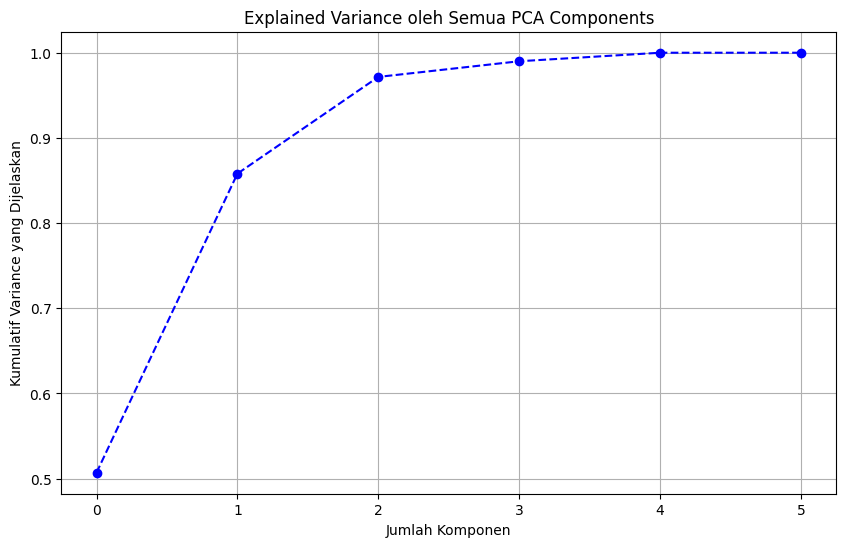

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data_cleaned, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === PCA untuk semua komponen ===
pca_full = PCA()  # tanpa n_components, supaya semua komponen dihitung
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Kumulatif Variance yang Dijelaskan')
plt.title('Explained Variance oleh Semua PCA Components')
plt.grid(True)
plt.show()


In [72]:
# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 3. PCA ===
pca = PCA(n_components=2)   # 3 biar bisa 2D/3D plot
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


In [73]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.53641946 0.34457442]
Total explained variance: 0.8809938806165778


Clustering progress:  11%|█         | 1/9 [00:06<00:48,  6.11s/it]

k=2, Silhouette Score=0.4272, Davies-Bouldin Index=0.9023


Clustering progress:  22%|██▏       | 2/9 [00:11<00:40,  5.77s/it]

k=3, Silhouette Score=0.4521, Davies-Bouldin Index=0.7670


Clustering progress:  33%|███▎      | 3/9 [00:17<00:33,  5.66s/it]

k=4, Silhouette Score=0.4010, Davies-Bouldin Index=0.8520


Clustering progress:  44%|████▍     | 4/9 [00:23<00:28,  5.75s/it]

k=5, Silhouette Score=0.3813, Davies-Bouldin Index=0.8657


Clustering progress:  56%|█████▌    | 5/9 [00:28<00:22,  5.53s/it]

k=6, Silhouette Score=0.3976, Davies-Bouldin Index=0.7894


Clustering progress:  67%|██████▋   | 6/9 [00:33<00:16,  5.44s/it]

k=7, Silhouette Score=0.3846, Davies-Bouldin Index=0.8314


Clustering progress:  78%|███████▊  | 7/9 [00:38<00:10,  5.26s/it]

k=8, Silhouette Score=0.3770, Davies-Bouldin Index=0.8176


Clustering progress:  89%|████████▉ | 8/9 [00:43<00:05,  5.33s/it]

k=9, Silhouette Score=0.3664, Davies-Bouldin Index=0.8101


Clustering progress: 100%|██████████| 9/9 [00:48<00:00,  5.43s/it]

k=10, Silhouette Score=0.3667, Davies-Bouldin Index=0.8168


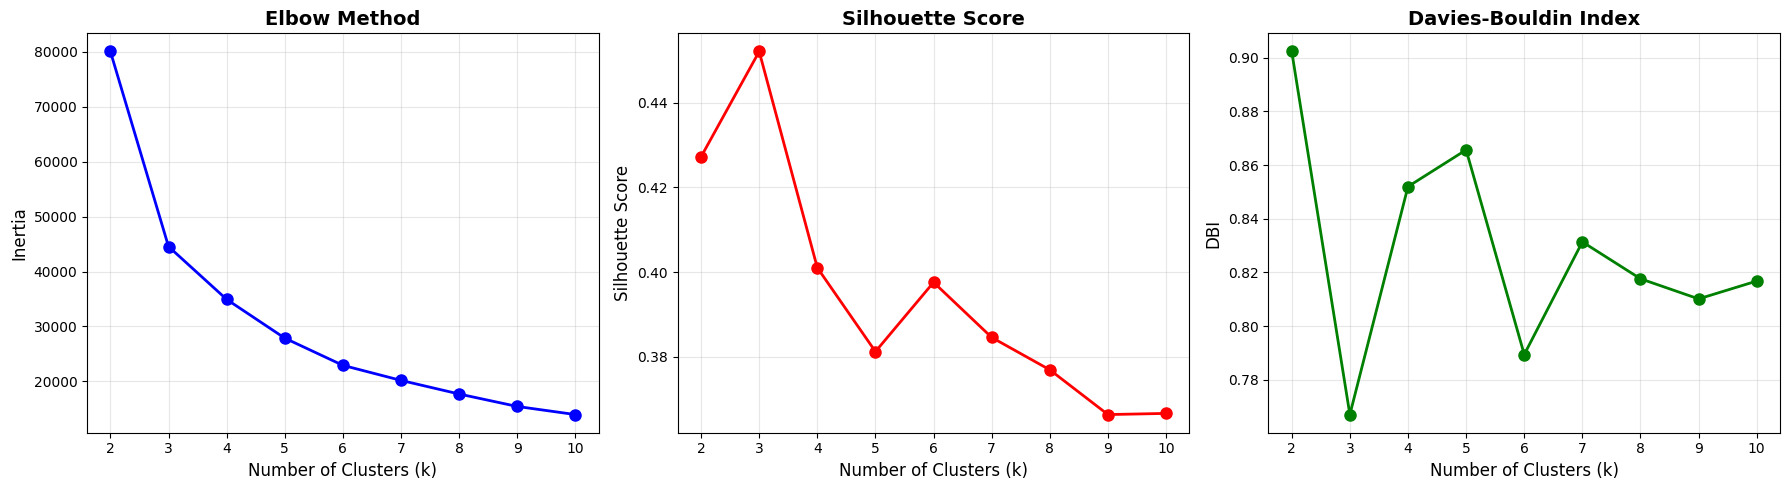

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Range jumlah cluster yang ingin diuji
K_range = range(2, 11)

inertias = []
sil_scores = []
dbi_scores = []

# Loop untuk setiap k
for k in tqdm(K_range, desc="Clustering progress"):
    # Latih KMeans pada data PCA 2D
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_train_pca)
    
    # Simpan inertia
    inertias.append(kmeans_temp.inertia_)
    
    # Hitung Silhouette Score
    sil_score = silhouette_score(X_train_pca, labels_temp)
    sil_scores.append(sil_score)
    
    # Hitung Davies-Bouldin Index
    dbi_score = davies_bouldin_score(X_train_pca, labels_temp)
    dbi_scores.append(dbi_score)
    
    # Print hasil untuk setiap k
    print(f"k={k}, Silhouette Score={sil_score:.4f}, Davies-Bouldin Index={dbi_score:.4f}")

# Plot hasil
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot Elbow Method
ax[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Number of Clusters (k)', fontsize=12)
ax[0].set_ylabel('Inertia', fontsize=12)
ax[0].grid(True, alpha=0.3)

# Plot Silhouette Score
ax[1].plot(K_range, sil_scores, 'ro-', linewidth=2, markersize=8)
ax[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Number of Clusters (k)', fontsize=12)
ax[1].set_ylabel('Silhouette Score', fontsize=12)
ax[1].grid(True, alpha=0.3)

# Plot Davies-Bouldin Index
ax[2].plot(K_range, dbi_scores, 'go-', linewidth=2, markersize=8)
ax[2].set_title('Davies-Bouldin Index', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Number of Clusters (k)', fontsize=12)
ax[2].set_ylabel('DBI', fontsize=12)
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [75]:
# === 4. KMeans Clustering ===
k = 3   # bisa pakai hasil dari elbow/silhouette loop sebelumnya
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters  = kmeans.predict(X_test_pca)

# Evaluasi cluster
sil = silhouette_score(X_train_pca, train_clusters)
dbi = davies_bouldin_score(X_train_pca, train_clusters)
print(f"Silhouette Score = {sil:.4f}, Davies-Bouldin Index = {dbi:.4f}")


Silhouette Score = 0.4521, Davies-Bouldin Index = 0.7670


In [76]:
# # === 4. KMeans Clustering ===
# k = 2  # bisa pakai hasil dari elbow/silhouette loop sebelumnya
# kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
# train_clusters = kmeans.fit_predict(X_train_pca)
# test_clusters  = kmeans.predict(X_test_pca)

# # Evaluasi cluster
# sil = silhouette_score(X_train_pca, train_clusters)
# dbi = davies_bouldin_score(X_train_pca, train_clusters)
# print(f"Silhouette Score = {sil:.4f}, Davies-Bouldin Index = {dbi:.4f}")

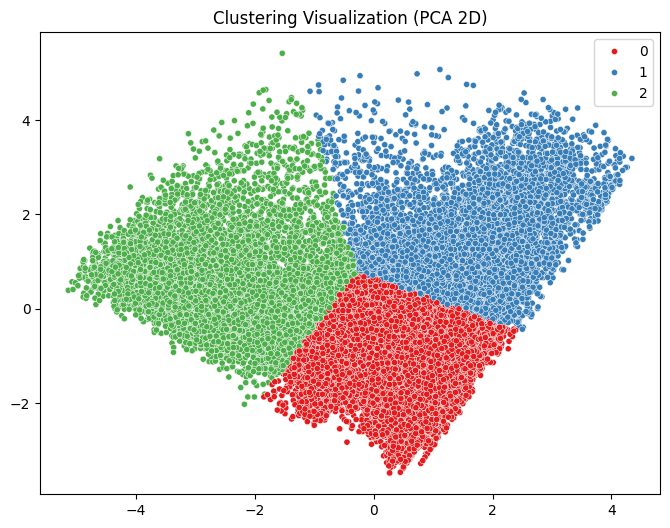

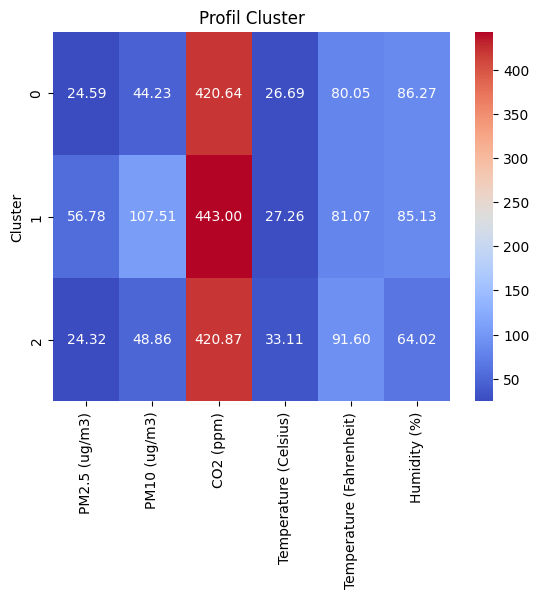

In [77]:
# Visualisasi PCA 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=train_clusters, palette="Set1", s=20)
plt.title("Clustering Visualization (PCA 2D)")
plt.show()

# === 5. Profil Cluster ===
X_train_copy = X_train.copy()
X_train_copy["Cluster"] = train_clusters
cluster_profile = X_train_copy.groupby("Cluster").mean()
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Profil Cluster")
plt.show()


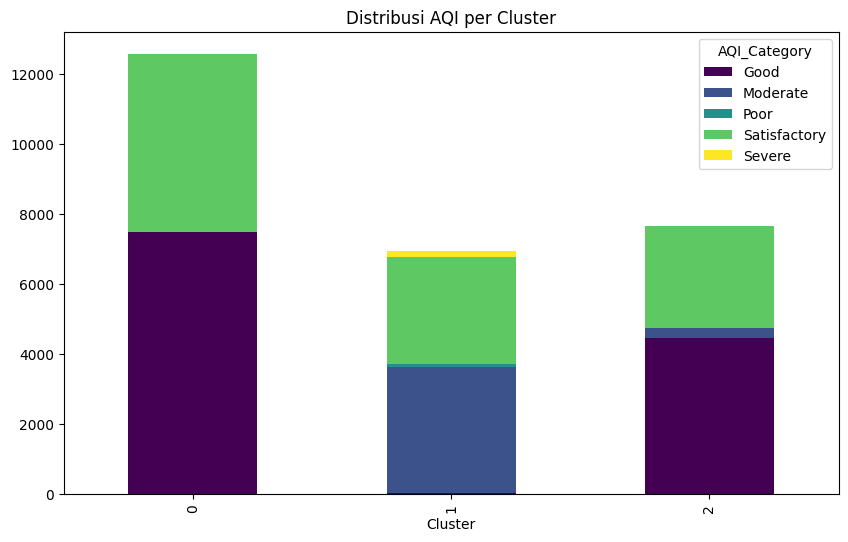

In [78]:
# === 6. Mapping AQI ===
breakpoints = {
    "PM2.5 (ug/m3)": [(0,30,0,50),(31,60,51,100),(61,90,101,200),(91,120,201,300),(121,250,301,400)],
    "PM10 (ug/m3)":  [(0,50,0,50),(51,100,51,100),(101,250,101,200),(251,350,201,300),(351,430,301,400)]
}

def calc_subindex(pollutant, conc):
    for Bmin,Bmax,Imin,Imax in breakpoints[pollutant]:
        if Bmin <= conc <= Bmax:
            return ((Imax-Imin)/(Bmax-Bmin))*(conc-Bmin)+Imin
    return np.nan

def calc_aqi(row):
    return max(calc_subindex("PM2.5 (ug/m3)", row["PM2.5 (ug/m3)"]),
               calc_subindex("PM10 (ug/m3)", row["PM10 (ug/m3)"]))
def categorize_aqi(val):
    if val <= 50: return "Good"
    elif val <= 100: return "Satisfactory"
    elif val <= 200: return "Moderate"
    elif val <= 300: return "Poor"
    elif val <= 400: return "Very Poor"
    else: return "Severe"

X_train_copy["AQI_Value"] = X_train_copy.apply(calc_aqi, axis=1)
X_train_copy["AQI_Category"] = X_train_copy["AQI_Value"].apply(categorize_aqi)

# Distribusi AQI per cluster
pd.crosstab(X_train_copy["Cluster"], X_train_copy["AQI_Category"]).plot(
    kind="bar", stacked=True, figsize=(10,6), colormap="viridis"
)
plt.title("Distribusi AQI per Cluster")
plt.show()


=== Random Forest ===
Accuracy: 0.9885091337654685
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3139
           1       0.98      0.98      0.98      1733
           2       0.99      0.99      0.99      1916

    accuracy                           0.99      6788
   macro avg       0.99      0.99      0.99      6788
weighted avg       0.99      0.99      0.99      6788



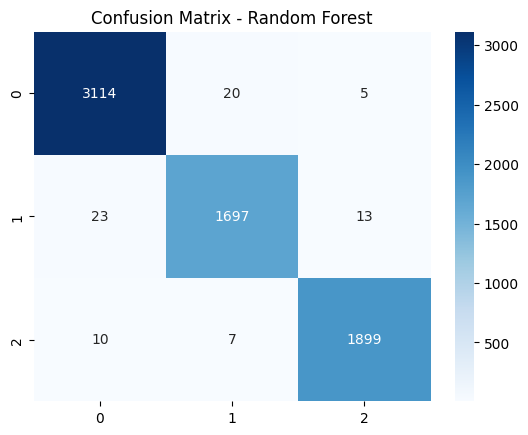


=== SVM ===
Accuracy: 0.9970536240424278
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3139
           1       1.00      1.00      1.00      1733
           2       1.00      1.00      1.00      1916

    accuracy                           1.00      6788
   macro avg       1.00      1.00      1.00      6788
weighted avg       1.00      1.00      1.00      6788



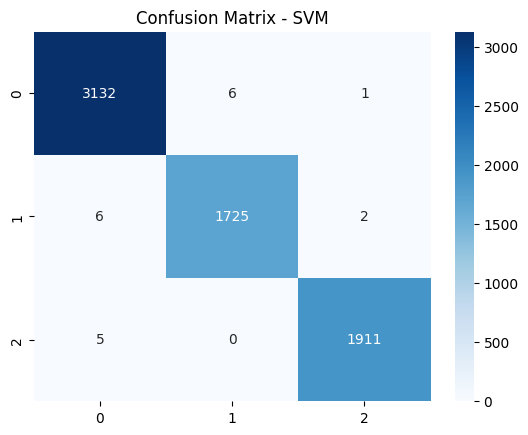


=== KNN ===
Accuracy: 0.9862993517972893
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3139
           1       0.98      0.98      0.98      1733
           2       0.99      0.99      0.99      1916

    accuracy                           0.99      6788
   macro avg       0.99      0.99      0.99      6788
weighted avg       0.99      0.99      0.99      6788



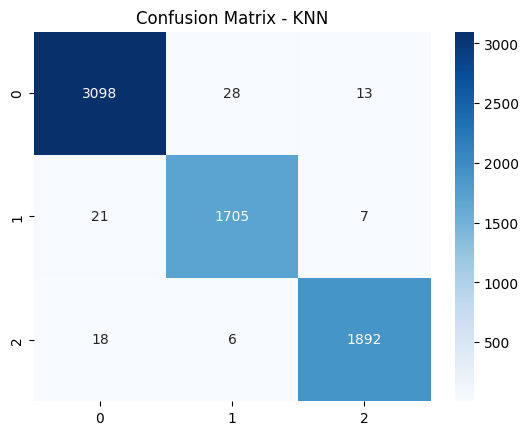


=== Naive Bayes ===
Accuracy: 0.9658220388921627
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3139
           1       0.95      0.95      0.95      1733
           2       0.96      1.00      0.98      1916

    accuracy                           0.97      6788
   macro avg       0.96      0.97      0.96      6788
weighted avg       0.97      0.97      0.97      6788



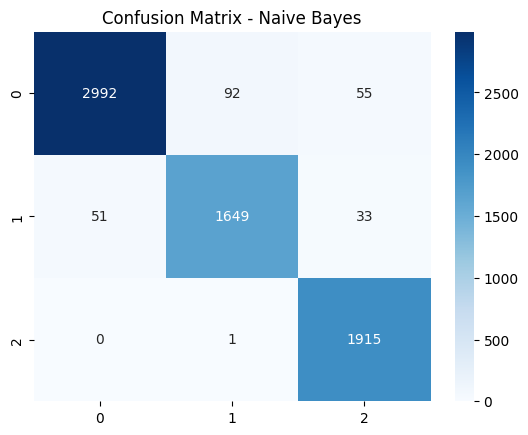


=== Decision Tree ===
Accuracy: 0.9796700058927519
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3139
           1       0.97      0.96      0.97      1733
           2       0.99      0.99      0.99      1916

    accuracy                           0.98      6788
   macro avg       0.98      0.98      0.98      6788
weighted avg       0.98      0.98      0.98      6788



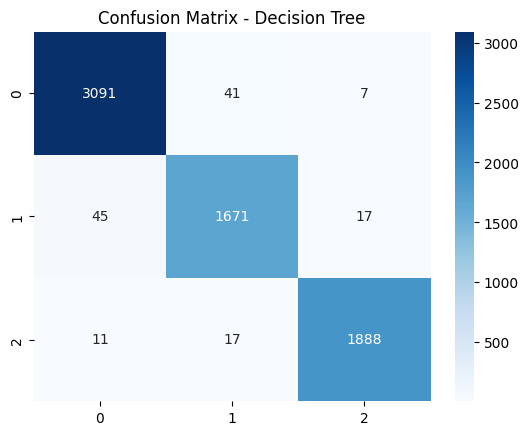

In [79]:
# === 7. Klasifikasi Supervised (pakai hasil cluster sebagai label) ===
X_final = np.vstack([X_train_scaled, X_test_scaled])
y_final = np.hstack([train_clusters, test_clusters])

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

for name, model in models.items():
    model.fit(X_train_cls, y_train_cls)
    y_pred = model.predict(X_test_cls)
    
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test_cls, y_pred))
    print(classification_report(y_test_cls, y_pred))
    
    sns.heatmap(confusion_matrix(y_test_cls, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()